In [1]:
import matplotlib.pyplot as plt
import torch
import json
import os
import pickle
colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]

In [2]:

def load_data_mocap(directory: str) -> dict:
    data = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pickle"):
            key, _, _ = filename.rpartition(".")
            with open(os.path.join(directory, filename), "rb") as f:
                v = pickle.load(f)
            if isinstance(v, dict):
                v = (torch.tensor(v["eigenvectors"]), torch.tensor(v["eigenvalues"]))
            else:
                v = torch.tensor(v)
            data[key] = v
    return data

ground_truth_data = load_data_mocap("/cephfs_projects/foundation_models/data/neurips_baseline_comparison_data/cmu_mocap_43_preprocessed_imputation_percentage_0_2/")
print(list(ground_truth_data.keys()))

['high_dim_trajectory', 'after_imputation_mask', 'observation_grid', 'high_dim_reconst_from_3_pca', 'fine_grid', 'before_imputation_mask', 'observation_mask', 'imputation_mask', 'observation_values', 'pca_params']


In [3]:
base_path = 'reports/FIMImputation/MocapData/09-13-1636/'
predictions_high_dim = torch.load(base_path + 'high_dim_predictions.pth')
predictions_pca = torch.load(base_path + 'pca_predictions.pth')




In [4]:
for k, v in predictions_pca.items():
    for ki, vi in v.items():
        print(f"{k:18} {ki:15} : {vi.shape}")

print("---")
for k, v in predictions_high_dim.items():
    for ki, vi in v.items():
        print(f"{k:18} {ki:15} : {vi.shape}")

B, wc, wlen, _ = predictions_pca['observations']['values'].shape

imputation_window  learnt          : torch.Size([43, 24, 3])
imputation_window  target          : torch.Size([43, 24, 3])
imputation_window  locations       : torch.Size([43, 24, 1])
imputation_window  drift           : torch.Size([43, 24, 3])
imputation_window  drift_certainty : torch.Size([43, 24, 3])
imputation_window  padding_mask_locations : torch.Size([43, 24])
observations       values          : torch.Size([43, 4, 64, 3])
observations       mask            : torch.Size([43, 4, 64, 1])
observations       times           : torch.Size([43, 4, 64, 1])
observations       denoised_values : torch.Size([43, 4, 64, 3])
observations       interpolation   : torch.Size([43, 4, 64, 3])
observations       drift           : torch.Size([43, 4, 64, 3])
observations       drift_certainty : torch.Size([43, 4, 64, 3])
---
imputation_window  learnt          : torch.Size([43, 24, 50])
imputation_window  target          : torch.Size([43, 24, 50])
imputation_window  locations       : torch.Size([43, 2

# Visualizations

In [5]:
# get 16 random samples
torch.manual_seed(0)
# unique sample ids
sample_ids = sorted(torch.randperm(B)[:16])
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)



[1, 2, 3, 4, 12, 13, 14, 19, 22, 26, 28, 29, 30, 31, 40, 42]


In [6]:
def plot_sample(line_plot_data: dict, sample_id: int, dim: int, ax, plot_imputation=True, plot_observations:bool=True):
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["values"].shape

    if plot_imputation:
        imputation_times = line_plot_data["imputation_window"]["locations"][sample_id]
        imputation_target = line_plot_data["imputation_window"]["target"][sample_id,:,dim]
        imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id,:, dim]

    for i in range(observed_window_count):
        if plot_observations:
            obs_mask = line_plot_data["observations"]["mask"][sample_id, i, :, 0]
            obs_times = line_plot_data["observations"]["times"][sample_id, i, :, 0][~obs_mask]
            obs_values = line_plot_data["observations"]["values"][sample_id, i, :, dim][~obs_mask]
            obs_interpolation = line_plot_data["observations"]["interpolation"][sample_id, i, :, dim][~obs_mask]

            ax.scatter(
                obs_times, obs_values, color=colors[i], marker="x", label=f"observed window {i}"
            )
            ax.plot(
                obs_times, obs_interpolation, color="black", linestyle="--", label=f"interpolation {i}"
            )
    if plot_imputation:
        ax.plot(
            imputation_times,imputation_target, color="black", linestyle=":", label="target"
        )
        ax.plot(imputation_times, imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title(f"{sample_id}, dim {dim}")
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


def plot_drift_sample(line_plot_data: dict, sample_id: int, dim: int, ax):
    obs_mask = line_plot_data["observations"]["mask"][sample_id,..., 0]
    drift_obs = line_plot_data["observations"]["drift"][sample_id,..., dim]
    drift_certainty_obs = line_plot_data["observations"]["drift_certainty"][sample_id,..., dim]
    times_obs = line_plot_data["observations"]["times"][sample_id,..., 0]

    imp_mask = line_plot_data["imputation_window"]["padding_mask_locations"][sample_id]
    drift_imp = line_plot_data["imputation_window"]["drift"][sample_id,:, dim][~imp_mask]
    drift_certainty_imp = line_plot_data["imputation_window"]["drift_certainty"][sample_id,:, dim][~imp_mask]
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id,:, 0][~imp_mask]


    for w in range(drift_obs.size(0)):
        ax.plot(times_obs[w][~obs_mask[w]], drift_obs[w][~obs_mask[w]], color=colors[w], linestyle="-", label=f"observed window {w}")
        ax.fill_between(
            times_obs[w][~obs_mask[w]],
            drift_obs[ w][~obs_mask[w]] - drift_certainty_obs[w][~obs_mask[w]],
            drift_obs[ w][~obs_mask[w]] + drift_certainty_obs[w][~obs_mask[w]],
            alpha=0.3,
            color=colors[w],
        )
    ax.plot(imputation_times, drift_imp, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift_imp - drift_certainty_imp,
        drift_imp + drift_certainty_imp,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.set_title(f"Drift {sample_id}, dim {dim}")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


## High Dim

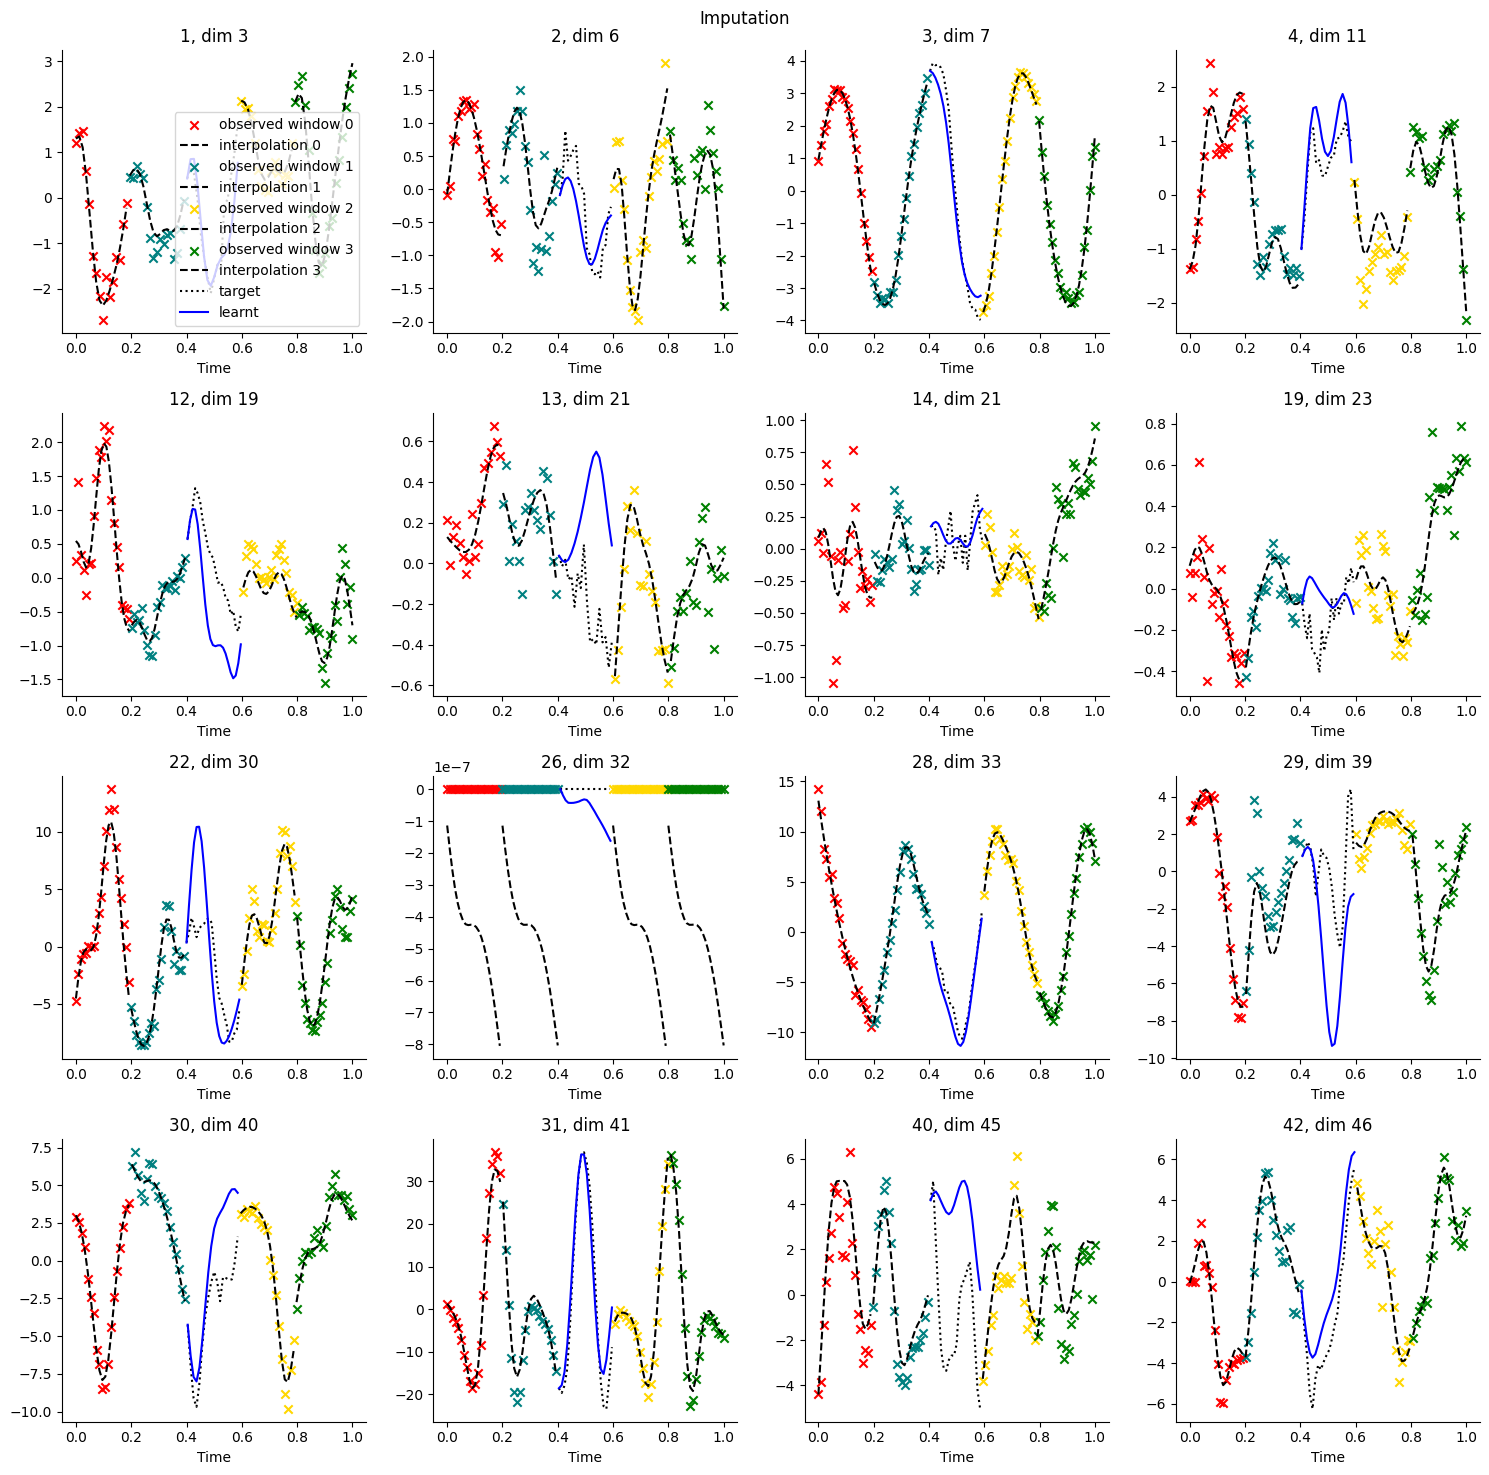

In [7]:
B, wc, wlen, D = predictions_high_dim['observations']['values'].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15,15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_high_dim, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0,0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_high_dim.png")
plt.show()


In [8]:
predictions_high_dim["observations"]["values"][24, 0, :, 25]

tensor([ 6.3478e-16, -2.3468e-14, -3.6140e-14, -6.3972e-15, -1.0348e-14,
        -7.5671e-16, -3.2363e-14,  6.3478e-16,  2.3893e-14,  9.9280e-15,
         1.4401e-14,  2.8960e-15,  7.4929e-15, -9.7517e-15, -1.1491e-14,
         2.6226e-15,  5.0080e-15, -4.7324e-15,  1.0773e-14, -1.0696e-14,
        -7.5154e-15, -6.3227e-15,  4.8093e-15,  2.4238e-15,  1.6736e-14,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])

# PCA space

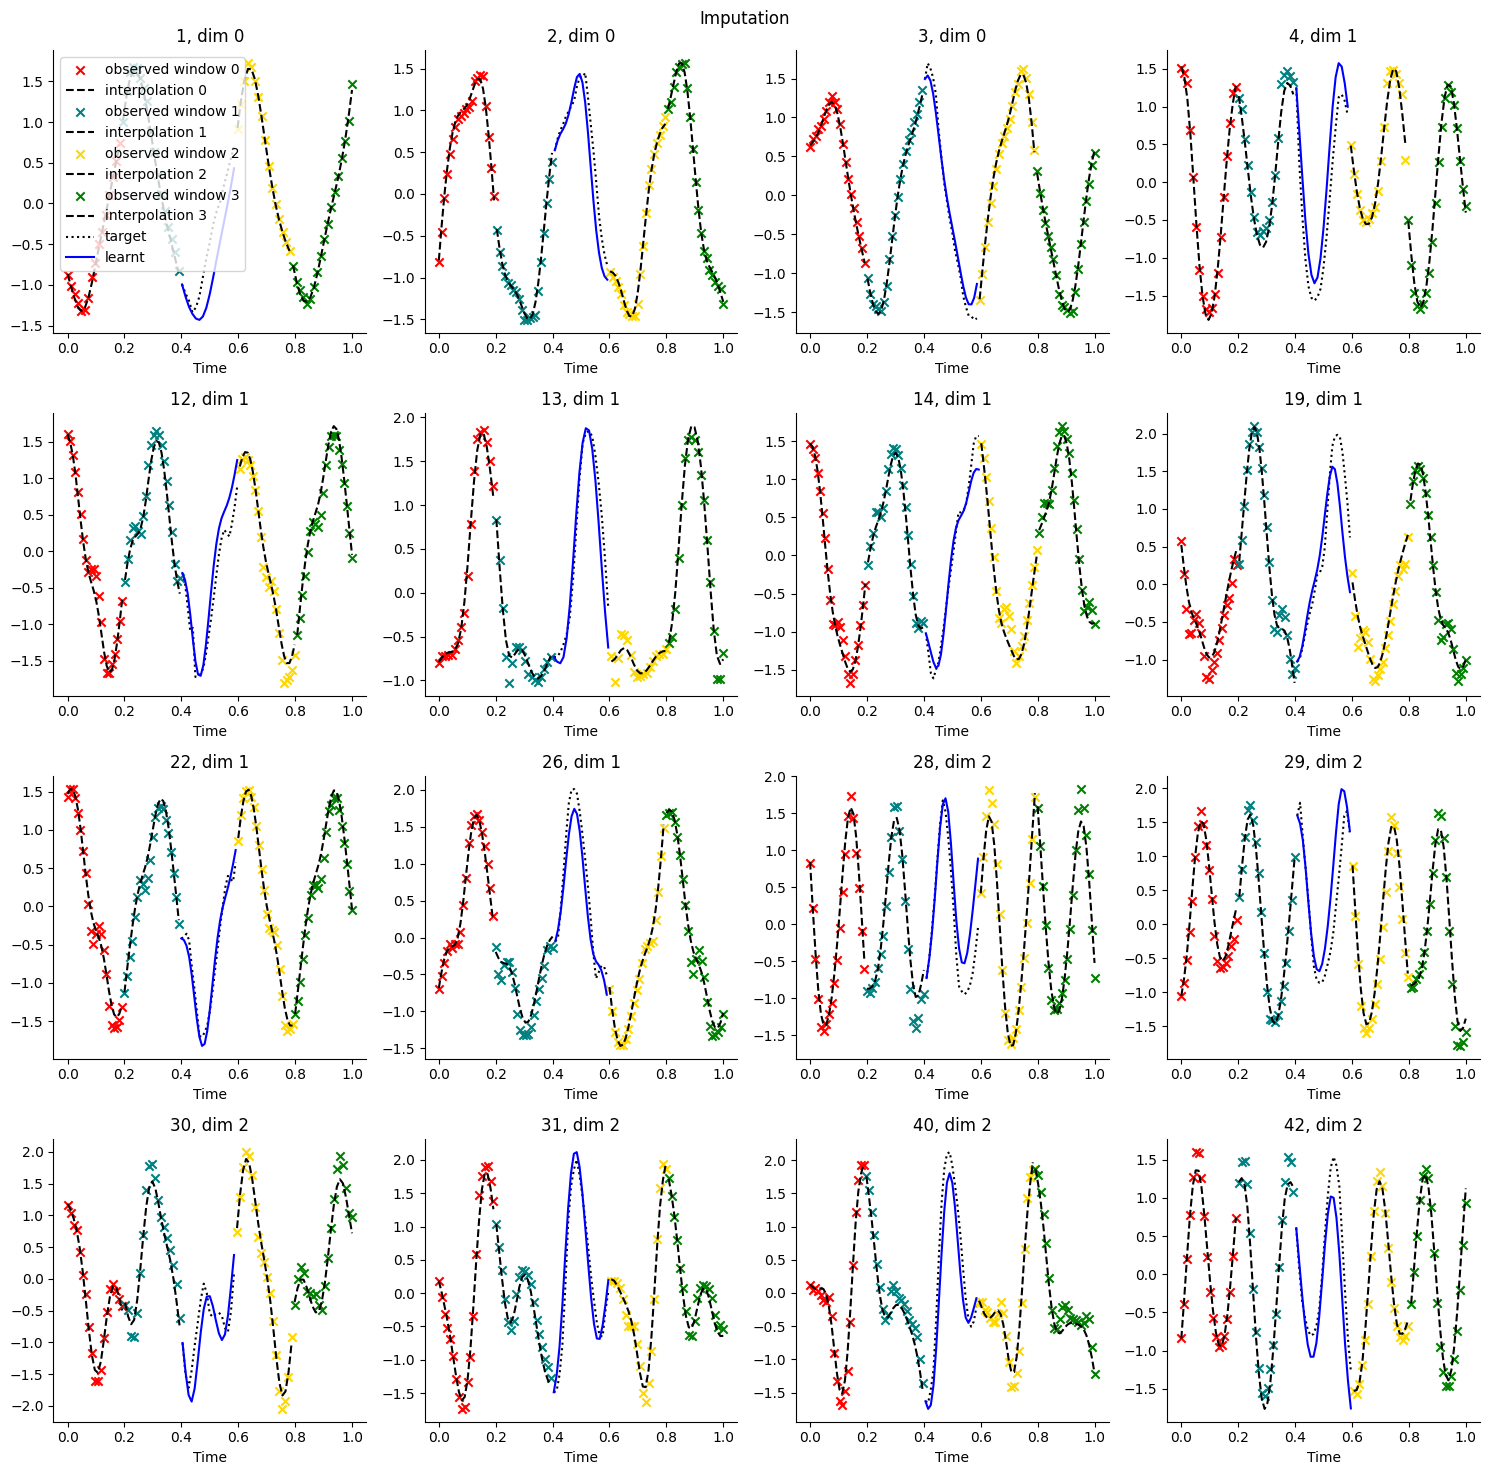

In [9]:
B, wc, wlen, D = predictions_pca['observations']['values'].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15,15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_pca, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0,0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_pca.png")
plt.show()

# Metrics

In [10]:

metrics_high_dim: dict = json.load(open(base_path + 'high_dim_metrics.json', "r"))
print('metrics_high_dim')
print(json.dumps(metrics_high_dim, indent=2))

metrics_high_dim
{
  "r2_score_mean": -1915505868800.0,
  "r2_score_std": 950432497664.0,
  "r2_score_above0.9": 0.0,
  "mae_mean": 1.6041483879089355,
  "mae_std": 0.5661524534225464,
  "mse_mean": 10.844532012939453,
  "mse_std": 9.204458236694336,
  "rmse_mean": 3.072394371032715,
  "rmse_std": 1.199323058128357
}


In [11]:
metrics_pca: dict = json.load(open(base_path + 'pca_metrics.json', "r"))
print('metrics_pca')
print(json.dumps(metrics_pca, indent=2))

metrics_pca
{
  "r2_score_mean": 0.8534103156588507,
  "r2_score_std": 0.13010521642743483,
  "r2_score_above0.9": 0.4883720874786377,
  "mae_mean": 0.9367570543307524,
  "mae_std": 0.5332376684659602,
  "mse_mean": 5.100995172642982,
  "mse_std": 5.726874732718795,
  "rmse_mean": 2.0232302395275763,
  "rmse_std": 1.0156394482539097
}


# plot single samples

In [12]:
# get sample id of worst performing prediction
predictions = predictions_pca # or predictions_pca
performance  = ((predictions["imputation_window"]["target"]- predictions["imputation_window"]["learnt"])**2).mean(dim=1).mean(dim=1)
print("performance per sample")
print(performance)
print(performance.mean())
print(torch.sqrt(performance.mean()))


performance per sample
tensor([0.0530, 0.1381, 0.1085, 0.1264, 0.1087, 0.3702, 0.1010, 0.0481, 0.0349,
        0.1931, 0.0812, 0.1533, 0.1020, 0.0542, 0.0837, 0.0410, 0.0599, 0.0827,
        0.0622, 0.1708, 0.0435, 0.0460, 0.0831, 0.0500, 0.0850, 0.0448, 0.0707,
        0.1957, 0.1373, 0.1069, 0.1229, 0.0651, 0.2192, 0.0310, 0.0377, 0.1211,
        0.1265, 0.1037, 0.3010, 0.1004, 0.1336, 0.1083, 0.1422])
tensor(0.1081)
tensor(0.3288)


In [13]:
(predictions["imputation_window"]["target"][0,:-8,:] - predictions["imputation_window"]["learnt"][0,:-8,:]).mean(dim=0).mean(dim=0)

tensor(-0.0181)

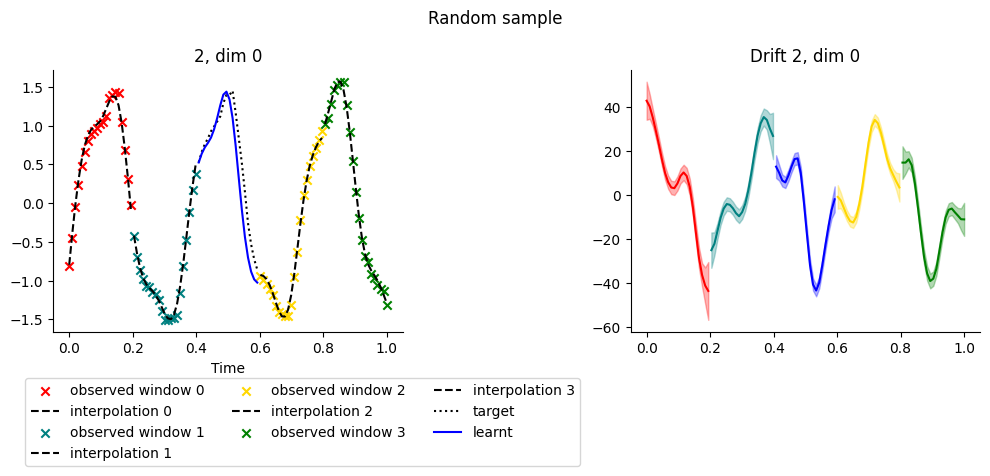

In [14]:
# random sample
sample_id = 2
dim = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, sample_id, dim, axs[0])
axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, sample_id, dim, axs[1])

fig.suptitle("Random sample")
plt.tight_layout()
plt.savefig(base_path + f"sample{sample_id}.png")
plt.show()



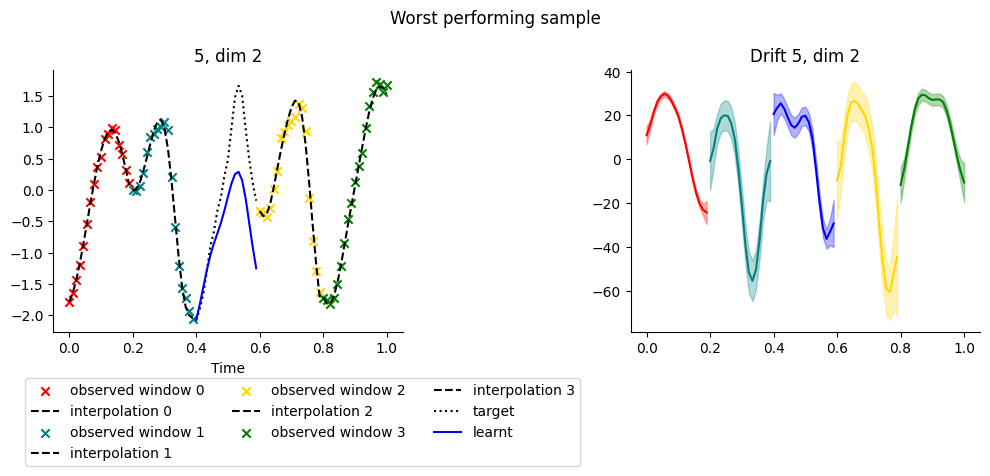

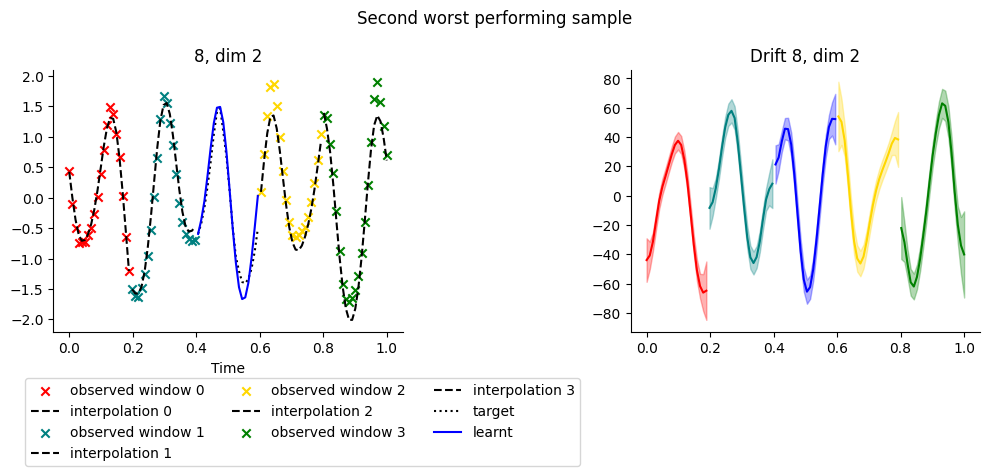

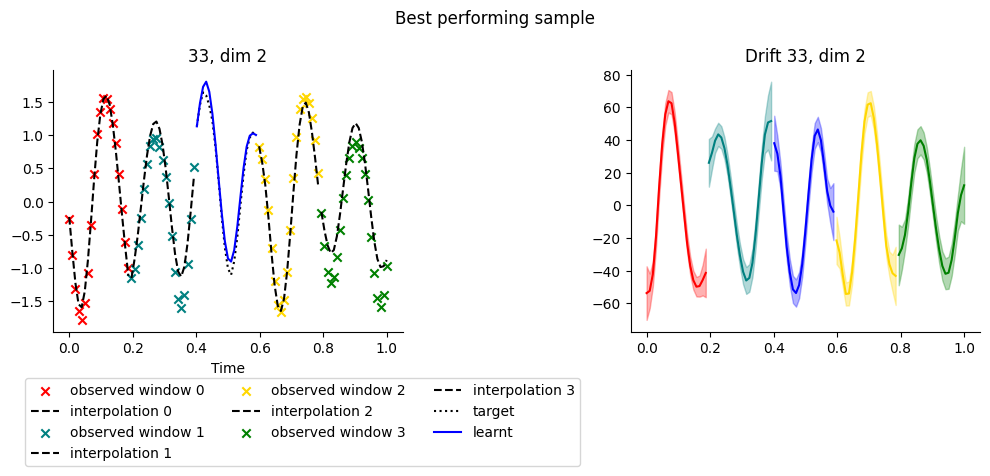

In [15]:
# worst performing sample
worst_sample_id = performance.argmax().item()

# plot worst performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, worst_sample_id, 2,  axs[0])
axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))

plot_drift_sample(predictions, worst_sample_id, 2, axs[1])
fig.suptitle("Worst performing sample")
plt.tight_layout()
plt.savefig(base_path + f"worst_sample{worst_sample_id}.png")

# second worst performing sample
second_worst_sample_id = performance.argsort()[1].item()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, second_worst_sample_id, 2,  axs[0])
axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, second_worst_sample_id, 2, axs[1])
fig.suptitle("Second worst performing sample")
plt.tight_layout()
plt.savefig(base_path + f"second_worst_sample{second_worst_sample_id}.png")
plt.show()

# best performing sample
best_sample_id = performance.argmin().item()

# plot best performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, best_sample_id, 2,  axs[0])
axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))

plot_drift_sample(predictions, best_sample_id, 2, axs[1])
fig.suptitle("Best performing sample")
plt.tight_layout()
plt.savefig(base_path + f"best_sample{best_sample_id}.png")
plt.show()
